# Problem: Bike rental forecast
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)


### Approach
- 1. Feature engineer the variables to be fit for the model 
- 2. Split train and test data set for validation 
- 3. Train a LinReg model 
- 3.1 Calculate test score and cross validate
- 4. Train and test Random Forest model
- 4.1 Calculate test score and cross validate
- 5. Optimize Hyperparameters

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.regression.linear_model import OLS
from scipy.stats import probplot
from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

%matplotlib inline

In [2]:
bike = pd.read_csv('/Users/sabrinafruhauf/Desktop/05_SpicedCourse/Week_03_regression/bike-sharing-demand/train.csv', parse_dates=True)
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 1. Feature engineering

In [4]:
bike["date"] = bike.datetime.apply(lambda x : x.split()[0])
bike["year_num"] = bike.date.apply(lambda x : x.split('-')[0]).astype('int')
bike["month_num"] = bike.date.apply(lambda x : x.split('-')[1]).astype('int')
bike["day_num"] = bike.date.apply(lambda x : x.split('-')[2]).astype('int')
bike["month"] = bike.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
bike["weekday"] = bike.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
bike["hour"] = bike.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype('int')
#bike.head()

In [ ]:
bike.isnull().sum()

In [ ]:
bike.dtypes

In [5]:
# add a ratio for registered users
bike['reg_ratio'] = bike['registered']/bike['count']

In [8]:
#onehot encoding columns month and weekday
onehot_year = pd.get_dummies(bike['year_num'],prefix='year_')
onehot_month = pd.get_dummies(bike['month'])
onehot_weekday = pd.get_dummies(bike['weekday'])
onehot_hour = pd.get_dummies(bike['hour'],prefix='hour_')

bike = pd.concat([bike, onehot_year,onehot_month, onehot_weekday, onehot_hour], axis=1)

In [9]:
# min/max scale temp and atemp
scaler = MinMaxScaler() # scales each column to a min of 0 and a max of 1.0

temp_x = bike['temp'].values.reshape(-1,1)
scaler.fit(temp_x)  # <-- scaler records the minimum and maximum

atemp_x = bike['atemp'].values.reshape(-1,1)
scaler.fit(atemp_x)

bike['temp_scaled'] = scaler.transform(temp_x)
bike['atemp_scaled'] = scaler.transform(atemp_x)

bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,temp_scaled,atemp_scaled
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,0,0,0,0,0,0,0.203155,0.305068
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,0,0,0,0,0,0,0,0.184808,0.288064
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,0,0,0,0,0,0,0,0.184808,0.288064
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,0,0,0,0,0,0,0,0.203155,0.305068
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,0,0,0,0,0,0,0,0.203155,0.305068


In [10]:
# add column for intercept (used in stats model later)
bike['intercept'] = 1

In [11]:
bike.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'year_num', 'month_num', 'day_num', 'month', 'weekday', 'hour',
       'reg_ratio', 'year__2011', 'year__2012', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'hour__0', 'hour__1', 'hour__2',
       'hour__3', 'hour__4', 'hour__5', 'hour__6', 'hour__7', 'hour__8',
       'hour__9', 'hour__10', 'hour__11', 'hour__12', 'hour__13', 'hour__14',
       'hour__15', 'hour__16', 'hour__17', 'hour__18', 'hour__19', 'hour__20',
       'hour__21', 'hour__22', 'hour__23', 'temp_scaled', 'atemp_scaled',
       'intercept'],
      dtype='object')

In [12]:
# reorder columns
bike = bike[['count','datetime','date', 'year_num', 'month_num', 'day_num', 'month', 'weekday', 'hour', 'season', 
             'holiday', 'workingday', 'weather', 'temp','temp_scaled','atemp', 'atemp_scaled', 'humidity', 
             'windspeed', 'casual', 'registered', 'reg_ratio',
             'year__2011', 'year__2012',
             'January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December',
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
             'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4','hour__5', 'hour__6', 'hour__7', 
             'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
             'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23',
             'intercept']]
bike.head()

,count,datetime,date,year_num,month_num,day_num,month,weekday,hour,season,...,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,intercept
0,16,2011-01-01 00:00:00,2011-01-01,2011,1,1,January,Saturday,0,1,...,0,0,0,0,0,0,0,0,0,1
1,40,2011-01-01 01:00:00,2011-01-01,2011,1,1,January,Saturday,1,1,...,0,0,0,0,0,0,0,0,0,1
2,32,2011-01-01 02:00:00,2011-01-01,2011,1,1,January,Saturday,2,1,...,0,0,0,0,0,0,0,0,0,1
3,13,2011-01-01 03:00:00,2011-01-01,2011,1,1,January,Saturday,3,1,...,0,0,0,0,0,0,0,0,0,1
4,1,2011-01-01 04:00:00,2011-01-01,2011,1,1,January,Saturday,4,1,...,0,0,0,0,0,0,0,0,0,1


In [13]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 68 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   count         10886 non-null  int64  
 1   datetime      10886 non-null  object 
 2   date          10886 non-null  object 
 3   year_num      10886 non-null  int64  
 4   month_num     10886 non-null  int64  
 5   day_num       10886 non-null  int64  
 6   month         10886 non-null  object 
 7   weekday       10886 non-null  object 
 8   hour          10886 non-null  int64  
 9   season        10886 non-null  int64  
 10  holiday       10886 non-null  int64  
 11  workingday    10886 non-null  int64  
 12  weather       10886 non-null  int64  
 13  temp          10886 non-null  float64
 14  temp_scaled   10886 non-null  float64
 15  atemp         10886 non-null  float64
 16  atemp_scaled  10886 non-null  float64
 17  humidity      10886 non-null  int64  
 18  windspeed     10886 non-nu

In [14]:
bike.columns

Index(['count', 'datetime', 'date', 'year_num', 'month_num', 'day_num',
       'month', 'weekday', 'hour', 'season', 'holiday', 'workingday',
       'weather', 'temp', 'temp_scaled', 'atemp', 'atemp_scaled', 'humidity',
       'windspeed', 'casual', 'registered', 'reg_ratio', 'year__2011',
       'year__2012', 'January', 'February', 'March', 'April', 'May', 'June',
       'July', 'August', 'September', 'October', 'November', 'December',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4',
       'hour__5', 'hour__6', 'hour__7', 'hour__8', 'hour__9', 'hour__10',
       'hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 'hour__16',
       'hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22',
       'hour__23', 'intercept'],
      dtype='object')

## 2. Split train and test data set for validation 


In [17]:
x = bike[['datetime','date','year_num','year__2011','year__2012', 'month_num', 'day_num', 'month', 'weekday', 'hour', 
          'season', 'holiday', 'workingday', 'weather', 'temp','temp_scaled','atemp', 'atemp_scaled', 'humidity', 
             'windspeed', 'casual', 'registered', 'reg_ratio',
             'January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December',
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
             'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4','hour__5', 'hour__6', 'hour__7', 
             'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
             'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23',
             'intercept']]
y = bike['count']
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((8708, 67), (2178, 67), (8708,), (2178,))

In [18]:
df_train = pd.concat([ytrain, xtrain], axis=1)
df_test = pd.concat([ytest, xtest], axis=1)

df_train.shape, df_test.shape

((8708, 68), (2178, 68))

## 3. Train a LinReg model 

In [42]:
# define x and y
x_train = df_train[['year__2011','year__2012','humidity', 'windspeed', 'season', 'holiday', 'workingday','temp_scaled', 
                    'atemp_scaled',
                    'January', 'February','March', 'April', 'May', 'June', 'July', 'August', 
                    'September','October', 'November', 'December', 
                    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
                    'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4','hour__5', 'hour__6', 'hour__7', 
                     'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
                     'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23']]
y_train = np.log1p(df_train['count'])

x_test = df_test[['year__2011','year__2012','humidity', 'windspeed', 'season', 'holiday', 'workingday','temp_scaled', 
                    'atemp_scaled',
                    'January', 'February','March', 'April', 'May', 'June', 'July', 'August', 
                    'September','October', 'November', 'December', 
                    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
                    'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4','hour__5', 'hour__6', 'hour__7', 
                     'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
                     'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23']]
y_test = np.log1p(df_test['count'])
# unused x features:
# not numerical:'datetime', 'date', 'weekday', 'month', 
# Numerical: 'hour', year_num','month_num', 'day_num', 'weather', 'temp', 'atemp','humidity', 'windspeed','casual', 'registered', 'year_num','reg_ratio'
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8708, 52), (2178, 52), (8708,), (2178,))

In [41]:
df_train.columns

Index(['count', 'datetime', 'date', 'year_num', 'year__2011', 'year__2012',
       'month_num', 'day_num', 'month', 'weekday', 'hour', 'season', 'holiday',
       'workingday', 'weather', 'temp', 'temp_scaled', 'atemp', 'atemp_scaled',
       'humidity', 'windspeed', 'casual', 'registered', 'reg_ratio', 'January',
       'February', 'March', 'April', 'May', 'June', 'July', 'August',
       'September', 'October', 'November', 'December', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour__0',
       'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
       'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
       'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
       'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23', 'intercept',
       'y_pred', 'residuals'],
      dtype='object')

In [62]:
#categorizing features into different list 
x_basic = ['hour', 'temp','year_num','month_num','day_num']
x_basic_scaled = ['hour', 'temp_scaled','year_num','month_num','day_num']
x_basic_plus = ['hour', 'temp','year_num','month_num','day_num','season','weather','holiday','workingday', 'humidity','windspeed']
x_basic_plus_scaled = ['hour', 'temp_scaled','year_num','month_num','day_num','season','weather','holiday','workingday', 'humidity','windspeed']
x_detail = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','temp']
x_detail_scaled = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','temp_scaled']
x_detail_plus = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','temp','season','weather','holiday','workingday', 'humidity','windspeed']
x_detail_plus_scaled = ['year__2011', 'year__2012','January','February', 'March', 'April', 'May', 'June', 
                     'July', 'August','September', 'October', 'November', 'December','Monday', 'Tuesday',
                     'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour__0',
                     'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6',
                     'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12',
                     'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18',
                     'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23','temp_scaled','atemp_scaled','season','weather','holiday','workingday', 'humidity','windspeed']

#grouping lists into models 
xIndex=[x_basic, x_basic_scaled, x_basic_plus, x_basic_plus_scaled, x_detail, x_detail_scaled,x_detail_plus,x_detail_plus_scaled]
modName=['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6','model 7','model 8']

In [63]:
def modPlots(xIndex, modName, mtype):
    y_train1=y_train
    mse_score=[]
    rmse_score=[]
    mae_score=[]
    r2score=[]
    msle_score=[]
    rmsle_score=[]

#regenrate needed models 
    for i in range(len(xIndex)):
        if mtype == 'linreg':
            m = LinearRegression()
        else:
            print('ERROR')
        
        x = df_train[xIndex[i]]
        m.fit(x, y_train1)
        y_predm=np.exp(m.predict(x))-1
        ##calculate model scores 
        mse_val=mean_squared_error(np.exp(y_train1)-1, y_predm, squared=True).round(3)
        mse_score.append(mse_val)
        rmse_val=mean_squared_error(np.exp(y_train1)-1, y_predm, squared=False).round(3)
        rmse_score.append(rmse_val)
        mae_val=mean_absolute_error(np.exp(y_train1)-1, y_predm).round(3)
        mae_score.append(mae_val)
        r2_val=r2_score(np.exp(y_train1)-1, y_predm).round(3)
        r2score.append(r2_val)
        msle_val=mean_squared_log_error(np.exp(y_train1)-1, y_predm).round(3)
        msle_score.append(msle_val)
        rmsle_val=np.sqrt(mean_squared_log_error(np.exp(y_train1)-1, y_predm).round(3))
        rmsle_score.append(rmsle_val)
    score_table=pd.DataFrame({'MeanSquaredError(MSE)': mse_score,'RootMeanSquaredError':rmse_score, 
                           'Mean Absolute Errors':mae_score, 'R2':r2score,
                           'MeanSquaredLogError': msle_score, 'RootMeanSquaredLogError(RMSLE)': rmsle_score}, index=modName)
        
    display(score_table)


In [64]:
modPlots(xIndex, modName, 'linreg')

,MeanSquaredError(MSE),RootMeanSquaredError,Mean Absolute Errors,R2,MeanSquaredLogError,RootMeanSquaredLogError(RMSLE)
model 1,30132.371,173.587,118.177,0.080,1.108,1.052616
model 2,30132.371,173.587,118.177,0.080,1.108,1.052616
model 3,25824.594,160.700,107.347,0.212,1.032,1.015874
model 4,25824.594,160.700,107.347,0.212,1.032,1.015874
model 5,9927.619,99.637,64.000,0.697,0.363,0.602495
model 6,9922.633,99.612,63.992,0.697,0.363,0.602495
model 7,9425.287,97.084,62.319,0.712,0.341,0.583952
model 8,9316.048,96.520,62.161,0.716,0.340,0.583095


In [20]:
#scores = []
m = LinearRegression()
m.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
df_train['y_pred'] = np.exp(m.predict(x_train))-1
df_test['y_pred'] = np.exp(m.predict(x_test))-1

In [22]:
print("R2 For Linear Regression Training score: ",r2_score(np.exp(y_train)-1, df_train['y_pred']).round(4))
print("R2 For Linear Regression test score: ",r2_score(np.exp(y_test)-1, df_test['y_pred']).round(4))

R2 For Linear Regression Training score:  0.7061
R2 For Linear Regression test score:  0.7057


In [23]:
# calculating the residuals
df_train['residuals'] = df_train['count'] - df_train['y_pred']
df_train.head()

,count,datetime,date,year_num,year__2011,year__2012,month_num,day_num,month,weekday,...,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23,intercept,y_pred,residuals
2815,35,2011-07-06 05:00:00,2011-07-06,2011,1,0,7,6,July,Wednesday,...,0,0,0,0,0,0,0,1,14.150222,20.849778
8695,450,2012-08-04 16:00:00,2012-08-04,2012,0,1,8,4,August,Saturday,...,0,0,0,0,0,0,0,1,632.126801,-182.126801
8406,276,2012-07-11 15:00:00,2012-07-11,2012,0,1,7,11,July,Wednesday,...,0,0,0,0,0,0,0,1,324.237884,-48.237884
1543,5,2011-04-10 04:00:00,2011-04-10,2011,1,0,4,10,April,Sunday,...,0,0,0,0,0,0,0,1,2.817557,2.182443
4952,200,2011-11-19 10:00:00,2011-11-19,2011,1,0,11,19,November,Saturday,...,0,0,0,0,0,0,0,1,139.599941,60.400059


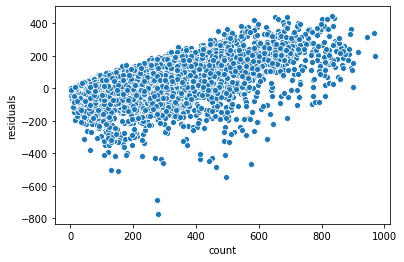

In [24]:
sns.scatterplot(x='count', y='residuals', data=df_train)

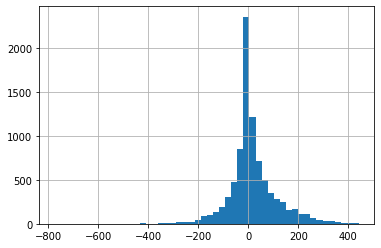

In [25]:
df_train['residuals'].hist(bins=50)

((array([-3.77627465, -3.5491955 , -3.42443716, ...,  3.42443716,
          3.5491955 ,  3.77627465]),
  array([-773.6320902 , -688.82105239, -545.82178625, ...,  435.12945812,
          440.8664269 ,  442.49849227])),
 (92.66429054405528, 16.9558893198785, 0.9583204499818377))

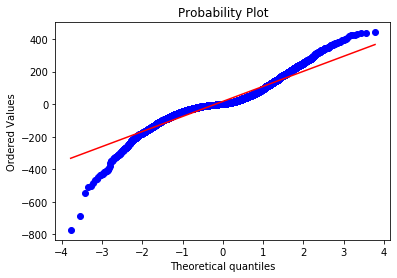

In [26]:
probplot(df_train['residuals'], plot=plt)

## 3.1 Plotting training data

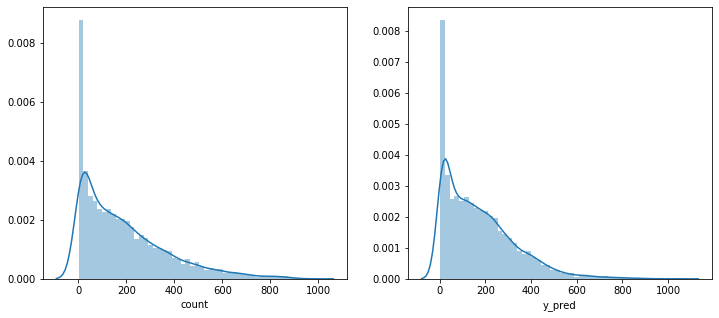

In [27]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(np.exp(y_train)-1,ax=ax1,bins=50)
sns.distplot(df_train['y_pred'],ax=ax2,bins=50)

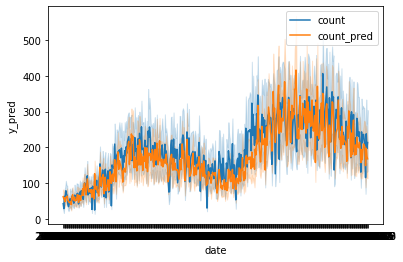

In [28]:
# plot your ypred against ytrue
# Training data
sns.lineplot(x="date", y="count", data=df_train, legend='brief', label=str('count'))
sns.lineplot(x="date", y="y_pred", data=df_train, legend='brief', label=str('count_pred'))


[Text(0.5, 1.0, 'plotting y_true and y_pred against humidity'), None]

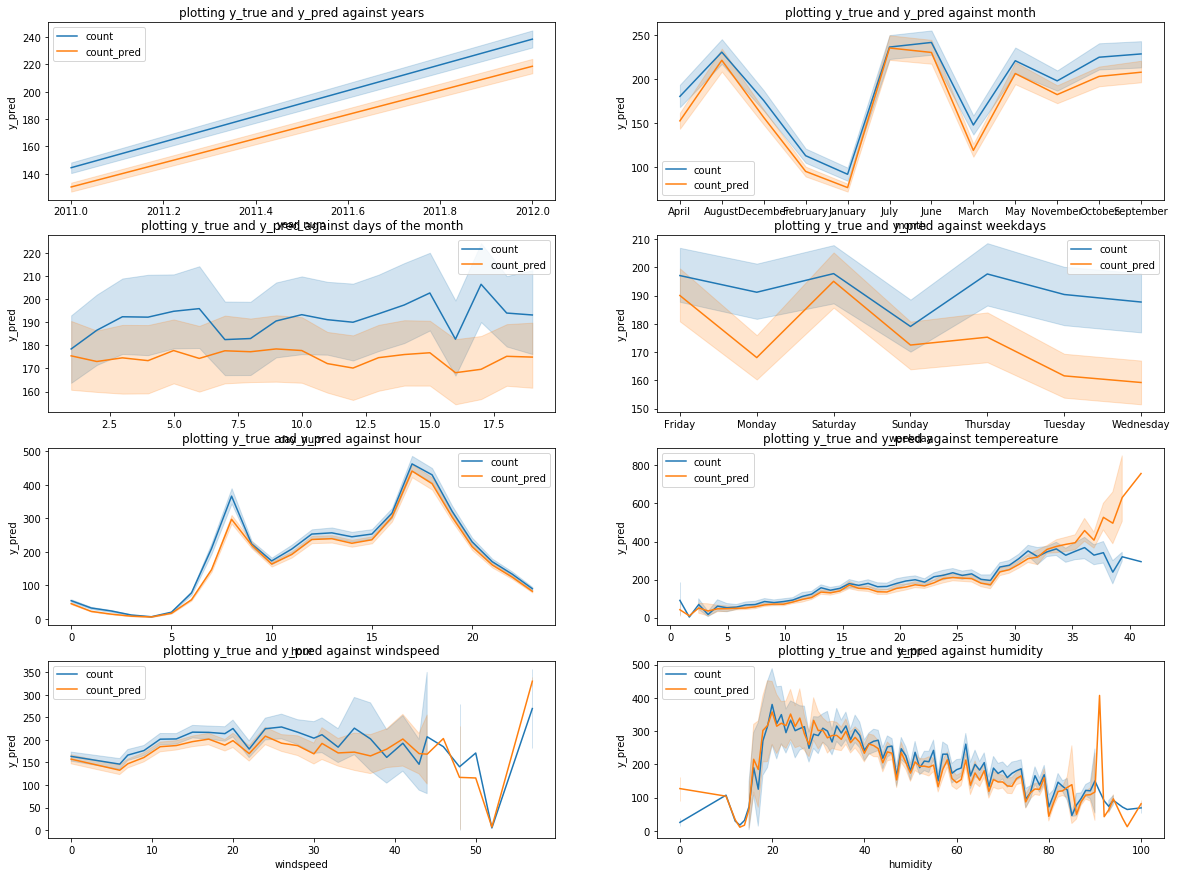

In [29]:
# plot your ypred against ytrue
# Training data
fig,((ax1,ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(20,15)
sns.lineplot(x="year_num", y="count", data=df_train, ax=ax1, legend='brief', label=str('count'))
sns.lineplot(x="year_num", y="y_pred", data=df_train, ax=ax1, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against years",
                                                  label='big')
sns.lineplot(x="month", y="count", data=df_train, ax=ax2, legend='brief', label=str('count'))
sns.lineplot(x="month", y="y_pred", data=df_train, ax=ax2, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against month",
                                                  label='big')
sns.lineplot(x="day_num", y="count", data=df_train, ax=ax3, legend='brief', label=str('count'))
sns.lineplot(x="day_num", y="y_pred", data=df_train, ax=ax3, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against days of the month",
                                                  label='big')
sns.lineplot(x="weekday", y="count", data=df_train, ax=ax4, legend='brief', label=str('count'))
sns.lineplot(x="weekday", y="y_pred", data=df_train, ax=ax4, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against weekdays",
                                                  label='big')
sns.lineplot(x="hour", y="count", data=df_train, ax=ax5, legend='brief', label=str('count'))
sns.lineplot(x="hour", y="y_pred", data=df_train, ax=ax5, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against hour",
                                                  label='big')
sns.lineplot(x="temp", y="count", data=df_train, ax=ax6, legend='brief', label=str('count'))
sns.lineplot(x="temp", y="y_pred", data=df_train, ax=ax6, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against tempereature",
                                                  label='big')
sns.lineplot(x="windspeed", y="count", data=df_train, ax=ax7, legend='brief', label=str('count'))
sns.lineplot(x="windspeed", y="y_pred", data=df_train, ax=ax7, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against windspeed",
                                                  label='big')
sns.lineplot(x="humidity", y="count", data=df_train, ax=ax8, legend='brief', label=str('count'))
sns.lineplot(x="humidity", y="y_pred", data=df_train, ax=ax8, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against humidity",
                                                  label='big')

In [30]:
#Mean squared error regression loss
print("MSE Value For Linear Regression: ",mean_squared_error(np.exp(y_train), df_train['y_pred'], squared=True).round(3))
print("Root-MSE Value For Linear Regression: ", mean_squared_error(np.exp(y_train), df_train['y_pred'], squared=False).round(3))

#MAE output is non-negative floating point. The best value is 0.0.
print("Mean absolute error For Linear Regression: ",mean_absolute_error(np.exp(y_train), df_train['y_pred']).round(3))

# R2 Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
print("R2 For Linear Regression: ",r2_score(np.exp(y_train), df_train['y_pred']).round(3))
#MSLE, RMSLE: 
print("MSLE For Linear Regression: ",mean_squared_log_error(np.exp(y_train), df_train['y_pred']).round(3))
print("RMSLE For Linear Regression: ",np.sqrt(mean_squared_log_error(np.exp(y_train), df_train['y_pred'])).round(3))


MSE Value For Linear Regression:  9664.658
Root-MSE Value For Linear Regression:  98.309
Mean absolute error For Linear Regression:  63.403
R2 For Linear Regression:  0.705
MSLE For Linear Regression:  0.326
RMSLE For Linear Regression:  0.571


## 3.2 Plotting testing data

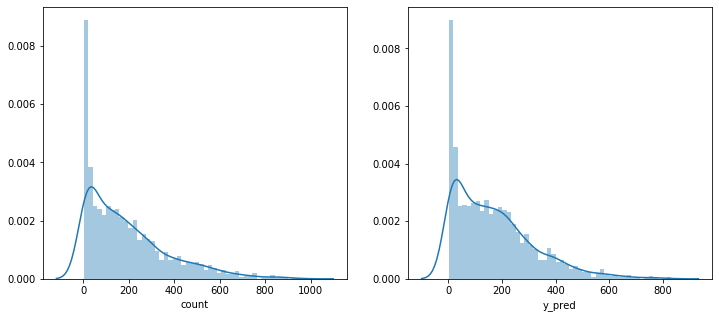

In [31]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(np.exp(y_test),ax=ax1,bins=50)
sns.distplot(df_test['y_pred'],ax=ax2,bins=50)

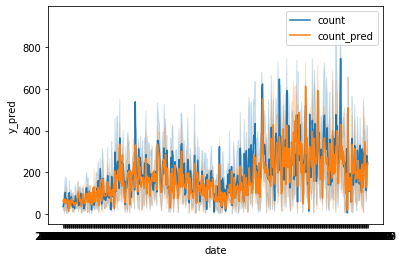

In [32]:
# plot your ypred against ytrue
# Testing data
sns.lineplot(x="date", y="count", data=df_test, legend='brief', label=str('count'))
sns.lineplot(x="date", y="y_pred", data=df_test, legend='brief', label=str('count_pred'))


[Text(0.5, 1.0, 'plotting y_true and y_pred against humidity'), None]

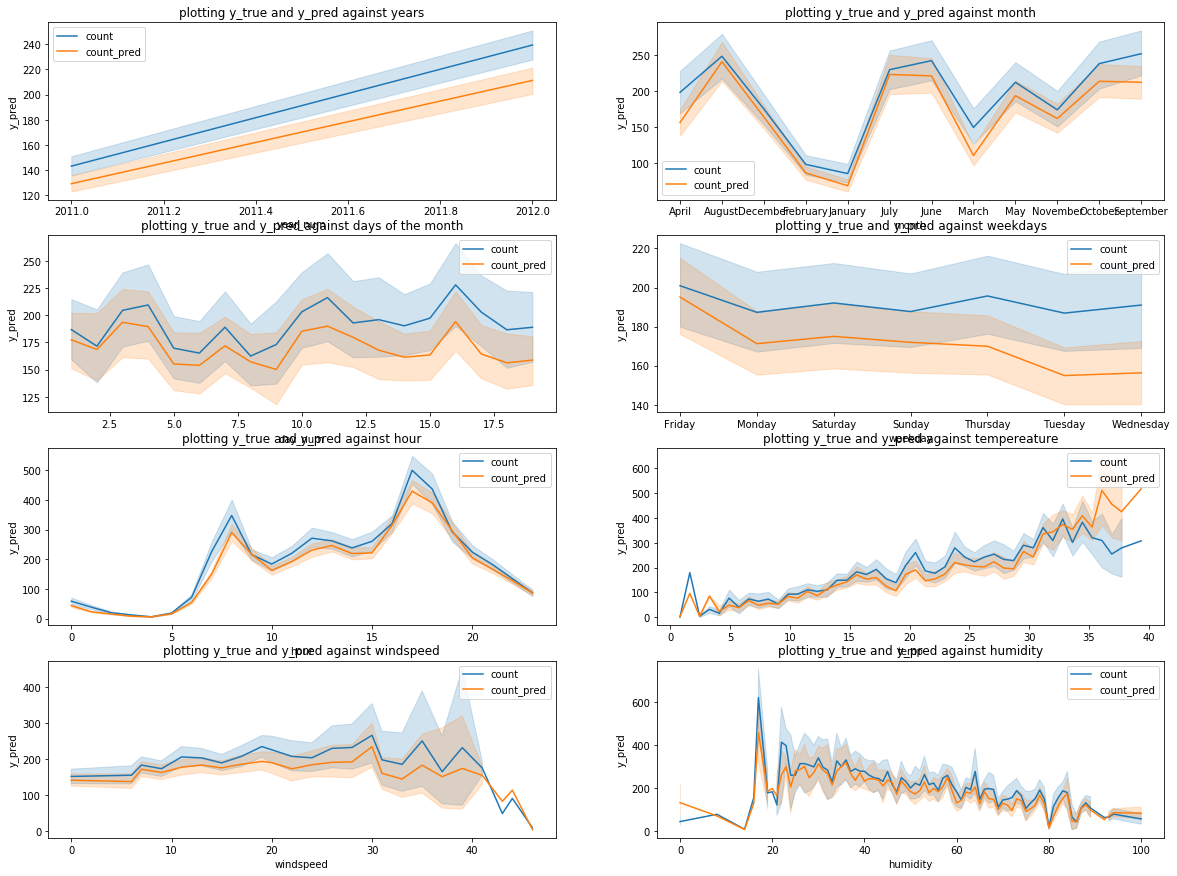

In [33]:
# plot your ypred against ytrue
# Test data
fig,((ax1,ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(20,15)
sns.lineplot(x="year_num", y="count", data=df_test, ax=ax1, legend='brief', label=str('count'))
sns.lineplot(x="year_num", y="y_pred", data=df_test, ax=ax1, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against years",
                                                  label='big')
sns.lineplot(x="month", y="count", data=df_test, ax=ax2, legend='brief', label=str('count'))
sns.lineplot(x="month", y="y_pred", data=df_test, ax=ax2, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against month",
                                                  label='big')
sns.lineplot(x="day_num", y="count", data=df_test, ax=ax3, legend='brief', label=str('count'))
sns.lineplot(x="day_num", y="y_pred", data=df_test, ax=ax3, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against days of the month",
                                                  label='big')
sns.lineplot(x="weekday", y="count", data=df_test, ax=ax4, legend='brief', label=str('count'))
sns.lineplot(x="weekday", y="y_pred", data=df_test, ax=ax4, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against weekdays",
                                                  label='big')
sns.lineplot(x="hour", y="count", data=df_test, ax=ax5, legend='brief', label=str('count'))
sns.lineplot(x="hour", y="y_pred", data=df_test, ax=ax5, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against hour",
                                                  label='big')
sns.lineplot(x="temp", y="count", data=df_test, ax=ax6, legend='brief', label=str('count'))
sns.lineplot(x="temp", y="y_pred", data=df_test, ax=ax6, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against tempereature",
                                                  label='big')
sns.lineplot(x="windspeed", y="count", data=df_test, ax=ax7, legend='brief', label=str('count'))
sns.lineplot(x="windspeed", y="y_pred", data=df_test, ax=ax7, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against windspeed",
                                                  label='big')
sns.lineplot(x="humidity", y="count", data=df_test, ax=ax8, legend='brief', label=str('count'))
sns.lineplot(x="humidity", y="y_pred", data=df_test, ax=ax8, legend='brief', label=str('count_pred')).set(
                                                  title="plotting y_true and y_pred against humidity",
                                                  label='big')

In [34]:
#Mean squared error regression loss
print("MSE Value For Linear Regression: ",mean_squared_error(np.exp(y_test), df_test['y_pred'], squared=True).round(3))
print("Root-MSE Value For Linear Regression: ", mean_squared_error(np.exp(y_test), df_test['y_pred'], squared=False).round(3))

#MAE output is non-negative floating point. The best value is 0.0.
print("Mean absolute error For Linear Regression: ",mean_absolute_error(np.exp(y_test), df_test['y_pred']).round(3))

# R2 Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
print("R2 For Linear Regression: ",r2_score(np.exp(y_test), df_test['y_pred']).round(3))
#MSLE, RMSLE: 
print("MSLE For Linear Regression: ",mean_squared_log_error(np.exp(y_test), df_test['y_pred']).round(3))
print("RMSLE For Linear Regression: ",np.sqrt(mean_squared_log_error(np.exp(y_test), df_test['y_pred'])).round(3))


MSE Value For Linear Regression:  9755.664
Root-MSE Value For Linear Regression:  98.771
Mean absolute error For Linear Regression:  64.029
R2 For Linear Regression:  0.704
MSLE For Linear Regression:  0.327
RMSLE For Linear Regression:  0.572


## 3.1 using statsmodel looking at the features


In [ ]:
# using statsmodel looking at the features
m_sm = OLS(y_train, df_train[['year_num', 'hour', 'season', 'holiday', 'workingday','temp_scaled', 'atemp_scaled', 
                    'reg_ratio', 'January', 'February','March', 'April', 'May', 'June', 'July', 'August', 
                    'September','October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 
                    'Thursday', 'Friday', 'Saturday', 'Sunday','hour__0', 'hour__1', 'hour__2', 'hour__3', 
                    'hour__4','hour__5', 'hour__6', 'hour__7', 
                     'hour__8', 'hour__9', 'hour__10','hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 
                     'hour__16','hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22','hour__23', 'intercept']])
result_sm = m_sm.fit()
result_sm.summary()